We are trying to determine which model gives us the closest resemblance to the actual prices ( LSTM vs ARIMA )

In [30]:
pip install pandas numpy matplotlib statsmodels tensorflow yfinance


Note: you may need to restart the kernel to use updated packages.


In [32]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [34]:
# Download data
data = yf.download('BTC-USD', start='2019-01-01', end='2023-01-01')
prices = data[['Close']].copy()

[*********************100%***********************]  1 of 1 completed


In [36]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices['Scaled'] = scaler.fit_transform(prices[['Close']])


In [38]:
def create_sequences(data, sequence_length=10):
    xs = []
    ys = []
    for i in range(len(data)-sequence_length-1):
        x = data[i:(i+sequence_length)]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [40]:
sequence_length = 10
X, y = create_sequences(prices['Scaled'].values, sequence_length)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [42]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# Fit LSTM Model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0680  
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014   
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 16

In [46]:
# Predict using LSTM
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [48]:
# Fit ARIMA Model
arima_model = ARIMA(prices['Close'], order=(5,1,0))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(steps=len(y_test))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [50]:
combined_forecast = (predicted_prices.flatten() + arima_pred) / 2

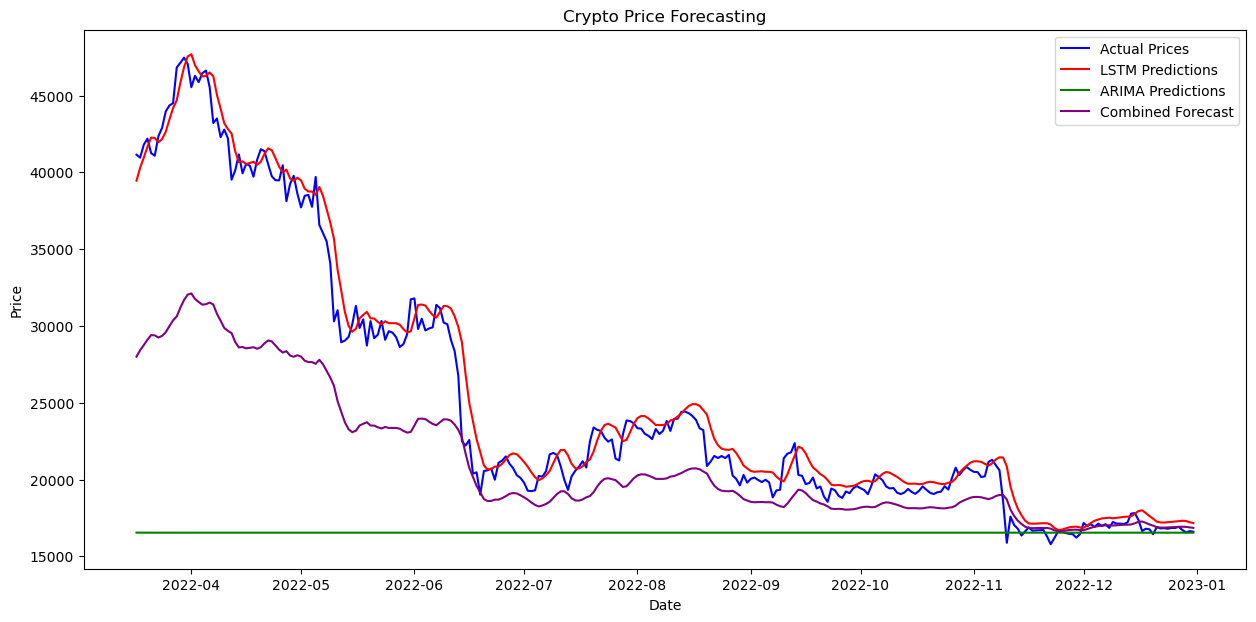

In [52]:
plt.figure(figsize=(15,7))
plt.plot(prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Prices', color='blue')
plt.plot(prices.index[-len(y_test):], predicted_prices, label='LSTM Predictions', color='red')
plt.plot(prices.index[-len(y_test):], arima_pred, label='ARIMA Predictions', color='green')
plt.plot(prices.index[-len(y_test):], combined_forecast, label='Combined Forecast', color='purple')
plt.title('Crypto Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Hence, it is better to use LSTM for our CrptoPricePrediction Model